# Basic workflow with ART for evasion attacks and defences

In this notebook we will show
- how to work with a Keras image classifier in ART
- how ART abstracts from the specific ML/DL backend
- how to apply a Projected Gradient Descent (PGD) evasion attack against that classifier
- how to deploy defences against such attacks
- how to create adversarial samples that can bypass those defences

Added by Ed Herranz (10/15/2022):
- how to protect against a white box attack agsint the defences

## Install and load prerequisites

You can preinstall all prerequisites by uncommenting and running the following cell.

In [1]:
!pip install adversarial-robustness-toolbox==1.12.1
!pip install tensorflow==2.10.0
!pip install keras==2.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 32.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.3.2
    Uninstalling scikit-learn-1.3.2:
      Successfully uninstalled scikit-learn-1.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.15.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.0.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 77.4 MB/s eta 0:00:00
  

^C


In [1]:


# Load basic dependencies:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import sys
import numpy as np

# Disable TensorFlow eager execution:
import tensorflow as tf
if tf.executing_eagerly():
    tf.compat.v1.disable_eager_execution()

# Load Keras dependencies:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image

# Load ART dependencies:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
from art.defences.preprocessor import SpatialSmoothing
from art.utils import to_categorical

# Install ImageNet stubs:
!{sys.executable} -m pip install git+https://github.com/nottombrown/imagenet_stubs
import imagenet_stubs
from imagenet_stubs.imagenet_2012_labels import name_to_label, label_to_name

  Cloning https://github.com/nottombrown/imagenet_stubs to /tmp/pip-req-build-38euo_gi
  Running command git clone --filter=blob:none --quiet https://github.com/nottombrown/imagenet_stubs /tmp/pip-req-build-38euo_gi
  Resolved https://github.com/nottombrown/imagenet_stubs to commit 0b501276f54cbf45b8e1b67dccbdcbe51de88365
  Preparing metadata (setup.py) ... done
  Created wheel for imagenet-stubs: filename=imagenet_stubs-0.0.7-py3-none-any.whl size=794799 sha256=2627aa18e1266c2ca514b1ff237d63eba26d833552996e9564761819bd1e3ca4
  Stored in directory: /tmp/pip-ephem-wheel-cache-us148dv_/wheels/11/fe/f6/71c84cfe4ee113c44af28273d506ccbd346c66da9db8688fe6
Successfully built imagenet-stubs


## Load images

We are going to load a set of 16 example images for illustration purposes.

In [2]:

images_list = list()
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    images_list.append(im)
    print(image_path)
    if 'beagle.jpg' in image_path:
        # get gazelle index
        gazelle_idx = i
images = np.array(images_list)


/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/beagle.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/sleeping_bag.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/centipede.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/notebook_computer.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/koala.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/standard_poodle.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/tractor.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/mitten.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/gazelle.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/manhole_cover.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/malamute.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/rock_crab.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/unicycle.jpg
/usr/lo

The images all have a resolution of 224 x 224 pixels, and 3 color channels (RGB).

In [3]:
print('Number of images:', images.shape[0])
print('Dimension of images:', images.shape[1], 'x', images.shape[2], 'pixels')
print('Number of color channels:', images.shape[3], '(RGB)')

Number of images: 16
Dimension of images: 224 x 224 pixels
Number of color channels: 3 (RGB)


As default choice, we are going to use the unicycle image for illustration purposes. But you could use any other of the 16 images in the following (just change the value of the `idx` variable).

In [6]:
images_list = list()
for i, image_path in enumerate(imagenet_stubs.get_image_paths()):
    im = image.load_img(image_path, target_size=(224, 224))
    im = image.img_to_array(im)
    images_list.append(im)
    print(image_path)
    if 'beagle.jpg' in image_path:
        # get gazelle index
        gazelle_idx = i
images = np.array(images_list)


/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/beagle.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/sleeping_bag.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/centipede.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/notebook_computer.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/koala.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/standard_poodle.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/tractor.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/mitten.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/gazelle.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/manhole_cover.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/malamute.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/rock_crab.jpg
/usr/local/lib/python3.10/dist-packages/imagenet_stubs/images/unicycle.jpg
/usr/lo

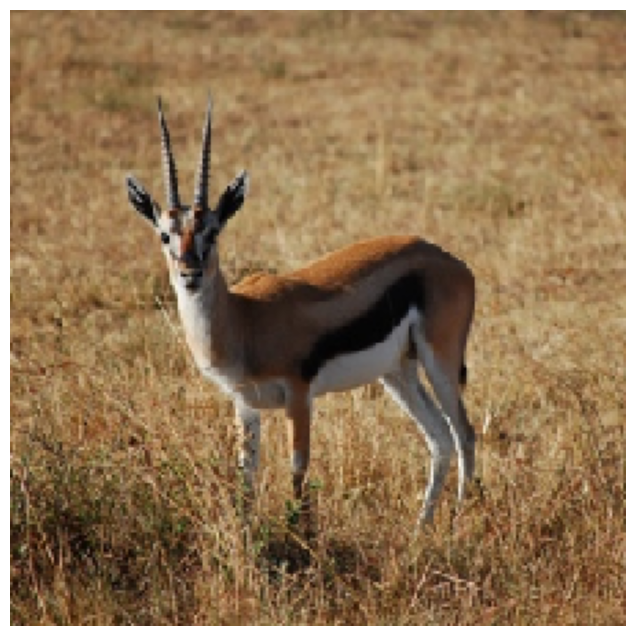

In [8]:
idx = gazelle_idx

plt.figure(figsize=(8,8))
plt.imshow(images[idx] / 255)
plt.axis('off')
plt.show()


## Load ResNet50 classifier

Next we are going to use a state-of-the-art classifier on those images.

In [10]:
# loads the pretrained ResNet50 model:
model = ResNet50(weights='imagenet')

Instructions for updating:
Colocations handled automatically by placer.


102967424/102967424 [==============================] - 1s 0us/step


Let's look at the prediction that this model yields for the selected image:

In [11]:
# expand the input dimension and apply the preprocessing required for ResNet50:
x = np.expand_dims(images[idx].copy(), axis=0)
x = preprocess_input(x)

# apply the model, determine the predicted label and confidence:
pred = model.predict(x)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction: gazelle - confidence 1.00


So the model correctly tells us that this image shows a unicycle/monocycle, which is good :-)

Next we will create an ART KerasClassifier wrapper around the model. <br>
We need to take care of the `preprocess_input` logic that has to be applied:

- swap the order of the color channels (RGB -> BGR)
- subtract the channel means

In [12]:
from art.preprocessing.preprocessing import Preprocessor

class ResNet50Preprocessor(Preprocessor):

    def __call__(self, x, y=None):
        return preprocess_input(x.copy()), y

    def estimate_gradient(self, x, gradient):
        return gradient[..., ::-1]

In [13]:
# Create the ART preprocessor and classifier wrapper:
preprocessor = ResNet50Preprocessor()
classifier = KerasClassifier(clip_values=(0, 255), model=model, preprocessing=preprocessor)

Now we will apply the classifier object to obtain the prediction.

**Note:** we have to swap the color channel order (from RGB to BGR) before feeding the input to the classifier

In [14]:
# Same as for the original model, we expand the dimension of the inputs.
x_art = np.expand_dims(images[idx], axis=0)

# Then apply the model through the classifier API, determine the predicted label and confidence:
pred = classifier.predict(x_art)
label = np.argmax(pred, axis=1)[0]
confidence = pred[:,label][0]

print('Prediction:', label_to_name(label), '- confidence {0:.2f}'.format(confidence))

Prediction: gazelle - confidence 1.00


So through the classifier API we obtain the same predictions as from the raw model, but now we have an abstraction from the actual backend (e.g. Keras).

The classifier wrapper allows us to call other functions besides predict.

For example, we can obtain the **loss gradient** of the classifier, which is used in many of the algorithms for adversarial sample generation:

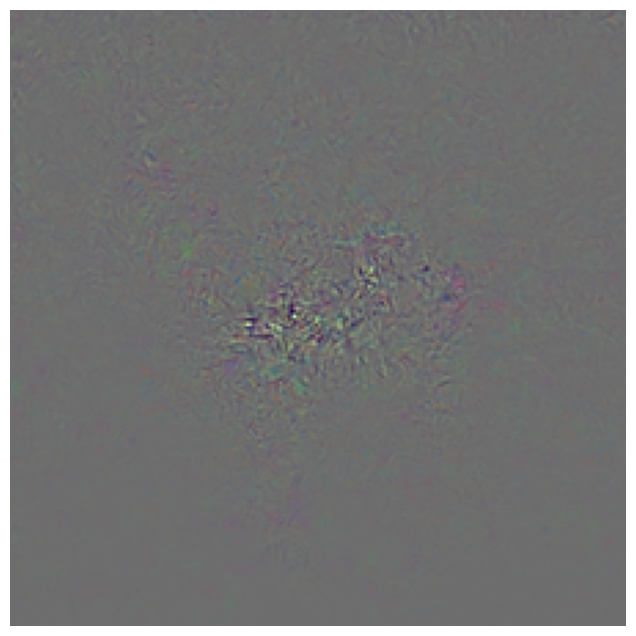

In [15]:
loss_gradient = classifier.loss_gradient(x=x_art, y=to_categorical([label], nb_classes=1000))

# plot the loss gradient.
# First, swap color channels back to RGB order:
loss_gradient_plot = loss_gradient[0]

# normalize loss gradient values to be in [0,1]:
loss_gradient_min = np.min(loss_gradient)
loss_gradient_max = np.max(loss_gradient)
loss_gradient_plot = (loss_gradient_plot - loss_gradient_min)/(loss_gradient_max - loss_gradient_min)

# Show plot:
plt.figure(figsize=(8,8)); plt.imshow(loss_gradient_plot); plt.axis('off'); plt.show()

## Create adversarial samples

Next, we are going to create an adversarial sample. <br>
We are going to use **Projected Gradient Descent (PGD)**, which is one of the strongest existing attacks. <br>
We will first perform an **untargeted** adversarial attack.

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

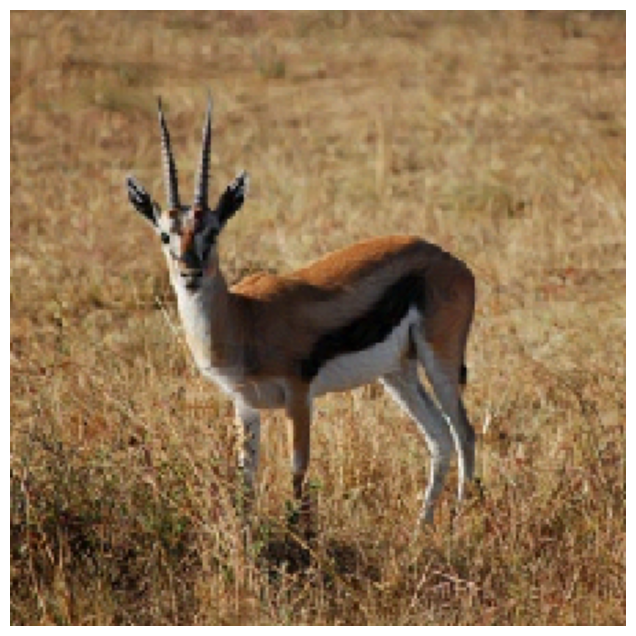

Prediction: impala, Aepyceros melampus - confidence 1.00


In [16]:
# Create the attacker:
adv = ProjectedGradientDescent(classifier, targeted=False, max_iter=10, eps_step=1, eps=5)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art)

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

Next, we will perform a **targeted attack** where we pick the class that we want the classifier to predict on the adversarial sample. <br>
Below is the list of labels and class names - make your pick!

In [17]:
for i in range(1000):
    print('label', i, '-', label_to_name(i))

label 0 - tench, Tinca tinca
label 1 - goldfish, Carassius auratus
label 2 - great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias
label 3 - tiger shark, Galeocerdo cuvieri
label 4 - hammerhead, hammerhead shark
label 5 - electric ray, crampfish, numbfish, torpedo
label 6 - stingray
label 7 - cock
label 8 - hen
label 9 - ostrich, Struthio camelus
label 10 - brambling, Fringilla montifringilla
label 11 - goldfinch, Carduelis carduelis
label 12 - house finch, linnet, Carpodacus mexicanus
label 13 - junco, snowbird
label 14 - indigo bunting, indigo finch, indigo bird, Passerina cyanea
label 15 - robin, American robin, Turdus migratorius
label 16 - bulbul
label 17 - jay
label 18 - magpie
label 19 - chickadee
label 20 - water ouzel, dipper
label 21 - kite
label 22 - bald eagle, American eagle, Haliaeetus leucocephalus
label 23 - vulture
label 24 - great grey owl, great gray owl, Strix nebulosa
label 25 - European fire salamander, Salamandra salamandra
label 26 

As default, let's get this image misclassified as black swan (label 100)!

In [18]:
target_label = 100

Now let's perform the targeted attack:

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/10 [00:00<?, ?it/s]

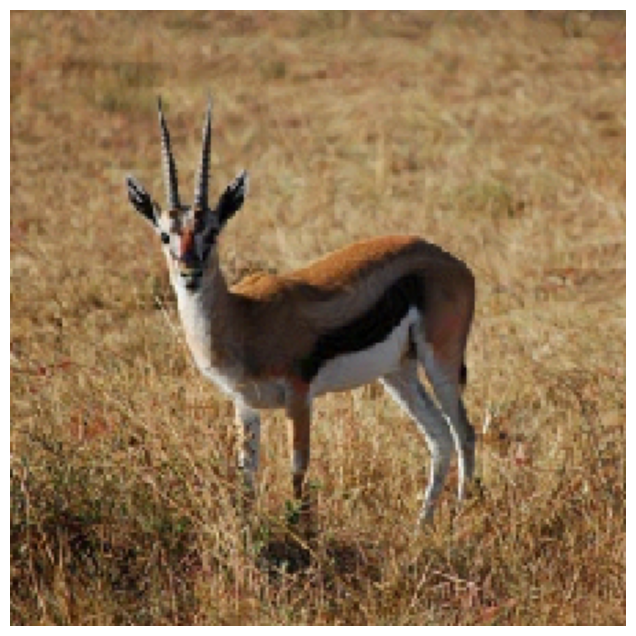

Prediction: black swan, Cygnus atratus - confidence 1.00


In [19]:
# Set the configuration to a targeted attack:
adv.set_params(targeted=True)

# Generate the adversarial sample:
x_art_adv = adv.generate(x_art, y=to_categorical([target_label]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier.predict(x_art_adv)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

We can measure the quantity of perturbation that was added to the image using different $\ell_p$ norms. <br>
**Note:** the PGD attack controls the $\ell_\infty$ norm via the `epsilon` parameter.

Perturbation l_0 norm: 81%
Perturbation l_1 norm: 3%
Perturbation l_2 norm: 3%
Noise l_inf norm: 2%


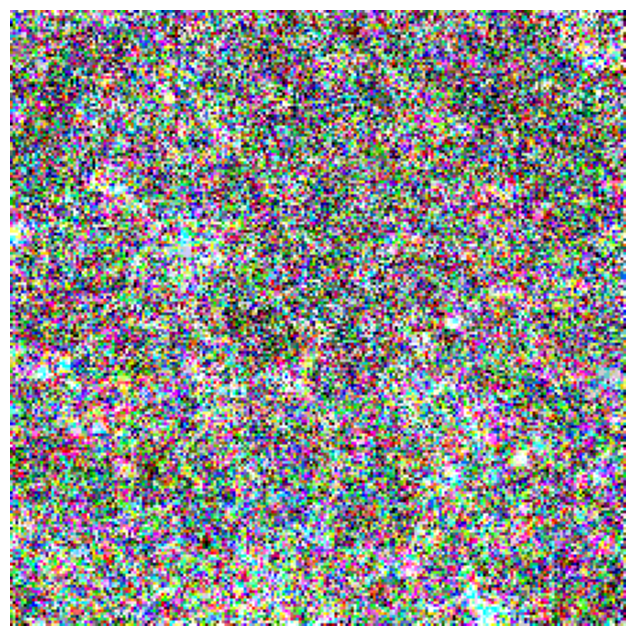

In [20]:
l_0 = int(99*len(np.where(np.abs(x_art[0] - x_art_adv[0])>0.5)[0]) / (224*224*3)) + 1
l_1 = int(99*np.sum(np.abs(x_art[0] - x_art_adv[0])) / np.sum(np.abs(x_art[0]))) + 1
l_2 = int(99*np.linalg.norm(x_art[0] - x_art_adv[0]) / np.linalg.norm(x_art[0])) + 1
l_inf = int(99*np.max(np.abs(x_art[0] - x_art_adv[0])) / 255) + 1

print('Perturbation l_0 norm: %d%%' % l_0)
print('Perturbation l_1 norm: %d%%' % l_1)
print('Perturbation l_2 norm: %d%%' % l_2)
print('Noise l_inf norm: %d%%' % l_inf)

# Let's also plot the absolute amount of adversarial pixel perturbations:
pert = np.abs(x_art[0] - x_art_adv[0])[..., ::-1]
pert_min = np.min(pert)
pert_max = np.max(pert)
plt.figure(figsize=(8,8)); plt.imshow((pert - pert_min) / (pert_max - pert_min)); plt.axis('off'); plt.show()

## Apply defences

Next we are going to apply a simple input preprocessing defence: Spatial Smoothing. <br>
Ideally, we want this defence to result in correct predictions when applied both to the original and the adversarial images.

In [39]:
from art.defences.preprocessor import FeatureSqueezing

# Initialize results list for Feature Squeezing
fs_results = []

# Loop over bit_depth values from 1 to 4
for bit_depth in range(1, 5):
    print(f"\nApplying Feature Squeezing with bit depth: {bit_depth}")

    # Apply Feature Squeezing defense with bit depth and clip values
    fs_defense = FeatureSqueezing(bit_depth=bit_depth, clip_values=(0, 255))

    # Apply the defense to the original and adversarial examples
    squeezed_original, _ = fs_defense(images)
    squeezed_adversarial, _ = fs_defense(adversarial_examples)

    # Get model predictions and confidence for the original and adversarial examples
    predictions_original = art_model.predict(squeezed_original)
    predictions_adversarial = art_model.predict(squeezed_adversarial)

    # Extract class and confidence (highest probability) for each prediction
    original_class = np.argmax(predictions_original, axis=1)
    original_confidence = np.max(predictions_original, axis=1)

    adversarial_class = np.argmax(predictions_adversarial, axis=1)
    adversarial_confidence = np.max(predictions_adversarial, axis=1)

    # Record results for this bit_depth
    for i in range(len(images)):  # Assuming batch processing
        fs_results.append({
            'Bit Depth': bit_depth,
            'Original Class': original_class[i],
            'Original Confidence': original_confidence[i],
            'Adversarial Class': adversarial_class[i],
            'Adversarial Confidence': adversarial_confidence[i]
        })

# Convert the results to a DataFrame for easy viewing
fs_results_df = pd.DataFrame(fs_results)

# Display the Feature Squeezing results
print("Feature Squeezing Results:")
display(fs_results_df)



Applying Feature Squeezing with bit depth: 1

Applying Feature Squeezing with bit depth: 2

Applying Feature Squeezing with bit depth: 3

Applying Feature Squeezing with bit depth: 4
Feature Squeezing Results:


Bit Depth  Original Class  Original Confidence  Adversarial Class  \
0           1             641             0.805058                641   
1           1             980             0.676289                980   
2           1             556             0.886151                556   
3           1             644             0.533406                644   
4           1             310             0.437170                310   
..        ...             ...                  ...                ...   
59          4             119             0.828790                119   
60          4             671             0.900068                671   
61          4             380             0.722490                380   
62          4             931             0.878353                931   
63          4             557             0.994115                557   

    Adversarial Confidence  
0                 0.805058  
1                 0.676289  
2                 0.886151  
3                 0.533406  
4                 0.437170  
..                     ...  
59                0.828790  
60                0.900068  
61                0.722490  
62                0.878353  
63                0.994115  

[64 rows x 5 columns]

Prediction of original sample: gazelle - confidence 1.00
Prediction of adversarial sample: gazelle - confidence 0.97


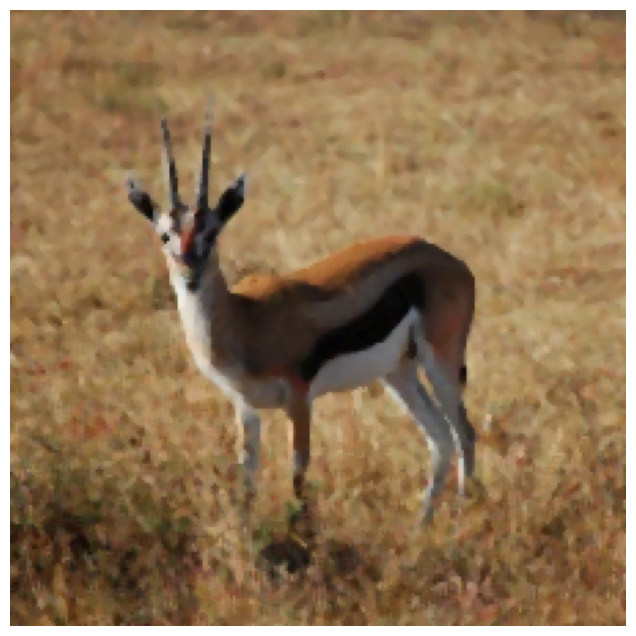

In [21]:
# Initialize the SpatialSmoothing defence.
ss = SpatialSmoothing(window_size=3)

# Apply the defence to the original input and to the adversarial sample, respectively:
x_art_def, _ = ss(x_art)
x_art_adv_def, _ = ss(x_art_adv)

# Compute the classifier predictions on the preprocessed inputs:
pred_def = classifier.predict(x_art_def)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

pred_adv_def = classifier.predict(x_art_adv_def)
label_adv_def = np.argmax(pred_adv_def, axis=1)[0]
confidence_adv_def = pred_adv_def[:, label_adv_def][0]

# Print the predictions:
print('Prediction of original sample:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))
print('Prediction of adversarial sample:', label_to_name(label_adv_def),
      '- confidence {0:.2f}'.format(confidence_adv_def))

# Show the preprocessed adversarial sample:
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()

In [29]:
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent

# Wrap the Keras model with ART's KerasClassifier
art_model = KerasClassifier(model=model, clip_values=(0, 255))

# Initialize the PGD attack with the wrapped model
attack = ProjectedGradientDescent(estimator=art_model, eps=0.1, eps_step=0.01, max_iter=40)

# Generate adversarial examples
adversarial_examples = attack.generate(x=images)


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

In [31]:
adversarial_examples = attack.generate(x=images)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

In [36]:
# Import the libraries
import pandas as pd

# Display the DataFrame
print("Spatial Smoothing Results:")
print(results_df)

from IPython.display import display
display(results_df)


Spatial Smoothing Results:
     Window Size  Original Class  Original Confidence  Adversarial Class  \
0              3             178             0.365629                178   
1              3             797             0.521881                797   
2              3              79             0.914952                 79   
3              3             681             0.744339                681   
4              3             105             0.973282                105   
..           ...             ...                  ...                ...   
123           10             124             0.305413                124   
124           10             862             0.744418                862   
125           10             971             0.069900                971   
126           10             931             0.116871                945   
127           10             657             0.145544                657   

     Adversarial Confidence  
0                  0.513681  


Window Size  Original Class  Original Confidence  Adversarial Class  \
0              3             178             0.365629                178   
1              3             797             0.521881                797   
2              3              79             0.914952                 79   
3              3             681             0.744339                681   
4              3             105             0.973282                105   
..           ...             ...                  ...                ...   
123           10             124             0.305413                124   
124           10             862             0.744418                862   
125           10             971             0.069900                971   
126           10             931             0.116871                945   
127           10             657             0.145544                657   

     Adversarial Confidence  
0                  0.513681  
1                  0.708627  
2                  0.892014  
3                  0.724042  
4                  0.939746  
..                      ...  
123                0.304321  
124                0.747763  
125                0.070054  
126                0.116694  
127                0.150709  

[128 rows x 5 columns]

## Perform adaptive whitebox attack to defeat defences

Next we are going to mount an adaptive whitebox attack in which the attacker aims at defeating the defence that we just put into place.

First, we create a classifier which incorporates the defence:

In [22]:
classifier_def = KerasClassifier(preprocessing=preprocessor, preprocessing_defences=[ss], clip_values=(0, 255),
                                 model=model)

# apply this classifier to the adversarial sample from before:
pred_def = classifier_def.predict(x_art_adv)
label_def = np.argmax(pred_def, axis=1)[0]
confidence_def = pred_def[:, label_def][0]

print('Prediction:', label_to_name(label_def), '- confidence {0:.2f}'.format(confidence_def))

Prediction: gazelle - confidence 0.97


We observe that this classifier reproduces the prediction that we had obtained before by manually applying the input preprocessing defence.

Now we create an adversarial sample against the *defended* classifier. <br>
As we are going to see, this adversarial sample is able to bypass the input preprocessing defence.

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

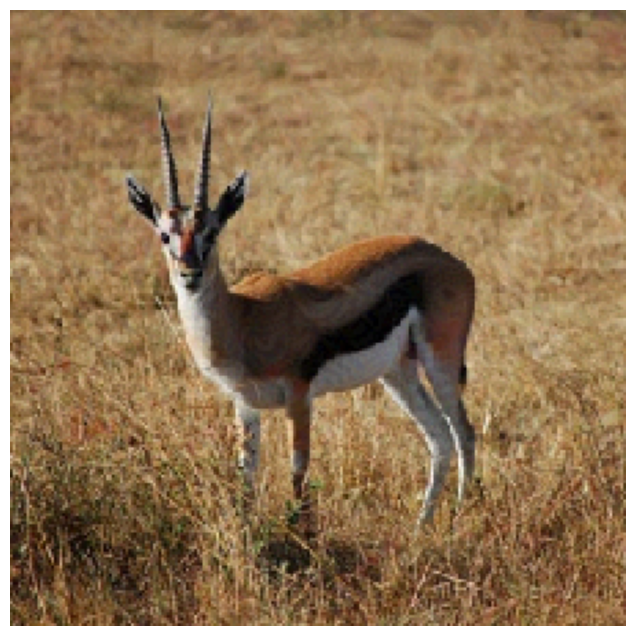

Prediction: black swan, Cygnus atratus - confidence 1.00


In [23]:
# Create the attacker.
# Note we use a larger number of iterations to achieve the same level of confidence in the misclassification
adv_def = ProjectedGradientDescent(classifier_def, targeted=True, max_iter=40, eps_step=1, eps=5)

# Generate the adversarial sample:
x_art_adv_def = adv_def.generate(x_art, y=to_categorical([target_label]))

# Plot the adversarial sample (note: we swap color channels back to RGB order):
plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()

# And apply the classifier to it:
pred_adv = classifier_def.predict(x_art_adv_def)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

Let's also look at the $\ell_p$ norms of that adversarial perturbation:

In [24]:
l_0 = int(99*len(np.where(np.abs(x_art[0] - x_art_adv_def[0])>0.5)[0]) / (224*224*3)) + 1
l_1 = int(99*np.sum(np.abs(x_art[0] - x_art_adv_def[0])) / np.sum(np.abs(x_art[0]))) + 1
l_2 = int(99*np.linalg.norm(x_art[0] - x_art_adv_def[0]) / np.linalg.norm(x_art[0])) + 1
l_inf = int(99*np.max(np.abs(x_art[0] - x_art_adv_def[0])) / 255) + 1

print('Perturbation l_0 norm: %d%%' % l_0)
print('Perturbation l_1 norm: %d%%' % l_1)
print('Perturbation l_2 norm: %d%%' % l_2)
print('Noise l_inf norm: %d%%' % l_inf)

Perturbation l_0 norm: 94%
Perturbation l_1 norm: 4%
Perturbation l_2 norm: 4%
Noise l_inf norm: 2%


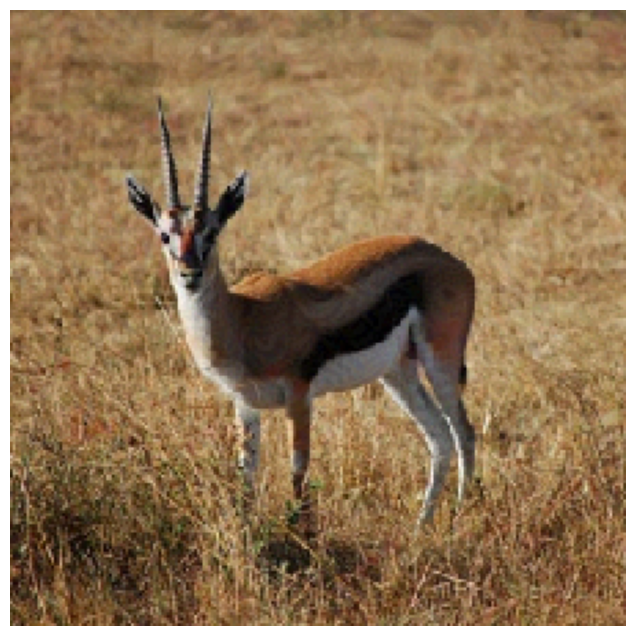

Prediction of whitebox adversarial attacked image with GaussiaNoise Post Processing: Greater Swiss Mountain dog - confidence 0.01
Prediction of original image with GaussianNoise Post Processing: clog, geta, patten, sabot - confidence 0.01
Prediction of whitebox adversarial attacked image with JpegCompression Pre-Processing: gazelle - confidence 1.00
Prediction of original image with JpegCompression Pre-Processing gazelle - confidence 1.00


In [25]:
#This part defend against the whitebox attack to defeat defences

from art.defences.postprocessor import GaussianNoise
from art.defences.preprocessor import JpegCompression

plt.figure(figsize=(8,8)); plt.imshow(x_art_adv_def[0] / 255); plt.axis('off'); plt.show()


classifier_def1 = KerasClassifier(preprocessing=preprocessor,  postprocessing_defences=GaussianNoise(scale=0.35), clip_values=(0, 255),
                               model=model)

# the GaussianNoise post-processing predicts the wrong class for the  whitebox adversarial attacked image
pred_adv = classifier_def1.predict(x_art_adv_def)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction of whitebox adversarial attacked image with GaussiaNoise Post Processing:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))


# the GaussianNoise post-processing predicts the wrong class for the  original image
pred_adv = classifier_def1.predict(x_art)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction of original image with GaussianNoise Post Processing:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

classifier_def2 = KerasClassifier(preprocessing=preprocessor, preprocessing_defences=JpegCompression(quality=50,clip_values=(0, 255)), clip_values=(0, 255),
                                 model=model)

# the JpegCompression pre-processing predicts the correct class for the  whitebox adversarial attacked image
pred_adv = classifier_def2.predict(x_art_adv_def)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction of whitebox adversarial attacked image with JpegCompression Pre-Processing:', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

# the JpegCompression pre-processing predicts the correct class for the original image
pred_adv = classifier_def2.predict(x_art)
label_adv = np.argmax(pred_adv, axis=1)[0]
confidence_adv = pred_adv[:, label_adv][0]
print('Prediction of original image with JpegCompression Pre-Processing', label_to_name(label_adv), '- confidence {0:.2f}'.format(confidence_adv))

In [38]:
from art.defences.preprocessor import JpegCompression, GaussianAugmentation

# the pixel values of images range from 0 to 255
clip_values = (0, 255)

# Initialize results lists
jpeg_results = []
gaussian_results = []

# 'art_model' is the ART-wrapped model and 'adversarial_examples' are already generated

# Loop over JPEG compression rates
for compression_rate in range(20, 95, 5):
    print(f"Applying JPEG Compression with quality: {compression_rate}")

    # Apply JPEG compression defense with clip_values
    jpeg_defense = JpegCompression(clip_values=clip_values, quality=compression_rate)
    compressed_original, _ = jpeg_defense(images)
    compressed_adversarial, _ = jpeg_defense(adversarial_examples)

    # Get predictions for the original and adversarial examples
    predictions_original = art_model.predict(compressed_original)
    predictions_adversarial = art_model.predict(compressed_adversarial)

    # Extract class and confidence for each prediction
    original_class = np.argmax(predictions_original, axis=1)
    original_confidence = np.max(predictions_original, axis=1)
    adversarial_class = np.argmax(predictions_adversarial, axis=1)
    adversarial_confidence = np.max(predictions_adversarial, axis=1)

    # Record results for this JPEG compression rate
    for i in range(len(images)):  # Assuming batch processing
        jpeg_results.append({
            'Compression Rate': compression_rate,
            'Original Class': original_class[i],
            'Original Confidence': original_confidence[i],
            'Adversarial Class': adversarial_class[i],
            'Adversarial Confidence': adversarial_confidence[i]
        })

# Convert the results to a DataFrame
jpeg_results_df = pd.DataFrame(jpeg_results)

# Display the JPEG compression results
print("JPEG Compression Results:")
display(jpeg_results_df)


Applying JPEG Compression with quality: 20
Applying JPEG Compression with quality: 25
Applying JPEG Compression with quality: 30
Applying JPEG Compression with quality: 35
Applying JPEG Compression with quality: 40
Applying JPEG Compression with quality: 45
Applying JPEG Compression with quality: 50
Applying JPEG Compression with quality: 55
Applying JPEG Compression with quality: 60
Applying JPEG Compression with quality: 65
Applying JPEG Compression with quality: 70
Applying JPEG Compression with quality: 75
Applying JPEG Compression with quality: 80
Applying JPEG Compression with quality: 85
Applying JPEG Compression with quality: 90
JPEG Compression Results:


Compression Rate  Original Class  Original Confidence  Adversarial Class  \
0                  20             162             0.456089                210   
1                  20             701             0.315418                701   
2                  20              65             0.626470                 65   
3                  20             681             0.907458                681   
4                  20             105             0.678188                359   
..                ...             ...                  ...                ...   
235                90             119             0.862059                120   
236                90             671             0.637778                671   
237                90             380             0.933733                377   
238                90             931             0.947379                616   
239                90             557             0.975801                557   

     Adversarial Confidence  
0                  0.398262  
1                  0.228410  
2                  0.714512  
3                  0.888728  
4                  0.434119  
..                      ...  
235                0.466652  
236                0.995940  
237                0.501897  
238                0.530942  
239                0.656396  

[240 rows x 5 columns]

Comparing with the previous adversarial sample, the $\ell_0$ and $\ell_1$ norms have slightly increased, while $\ell_2$ and $\ell_\infty$ norms have stayed the same (the latter not being surprising as the PGD attack controls the $\ell_\infty$ norm budget).

## Conclusions

We have walked through an end-to-end example of using a Keras image classifier in ART, creating adversarial samples, deploying input preprocessing defences and, finally, bypassing those defences in an adaptive white-box attack.